In [ ]:
import torch
import torchvision
import sklearn
import matplotlib
import numpy as np

print("PyTorch version:", torch.__version__)
print("TorchVision version:", torchvision.__version__)
print("scikit-learn version:", sklearn.__version__)
print("Matplotlib version:", matplotlib.__version__)
print("NumPy version:", np.__version__)


PyTorch version: 2.4.0+cu118
TorchVision version: 0.19.0+cu118
scikit-learn version: 1.5.1
Matplotlib version: 3.9.2
NumPy version: 1.26.3


Verificamos si tenemos CUDA disponible, este cuadernillo se corrió de manera local, por tanto, nos detecta nuestra tarjeta gráfica NVIDIA GeForce GTX 1060 de 6GB de memoria

In [ ]:
import torch

# Verificar si CUDA está disponible
cuda_available = torch.cuda.is_available()

# Imprimir si CUDA está disponible y la versión de CUDA
print(f"CUDA disponible: {cuda_available}")

if cuda_available:
    print(f"Versión de CUDA: {torch.version.cuda}")
    print(f"Dispositivo CUDA: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA no está disponible.")


CUDA disponible: True
Versión de CUDA: 11.8
Dispositivo CUDA: NVIDIA GeForce GTX 1060 6GB


# Importar  Dataset

Las imagenes se las tiene en formato .jpg, no están en un archivo .csv ya que se generaba un archivo extremadamente grande (20gbs) con todas las imagenes.
Sin embargo, utilizando el enfoque de utilizar tensores directamente al cargar las imágenes, el proceso fue mas rápido y liviano.
Simplemente hay que cargar las imagenes en una carpeta que contenga subcarpetas, donde cada subcarpeta representa una categoría.

In [ ]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedShuffleSplit

# Ruta a la carpeta en Google Drive donde están las imágenes
image_dir = 'hojas2000'

# Definir las transformaciones para las imágenes
transform = transforms.Compose([
    transforms.Resize((192, 256)),  # Redimensionar a 256x192
    transforms.ToTensor(),  # Convertir a tensor
])

# Cargar las imágenes y organizarlas en clases automáticamente según las carpetas
dataset = datasets.ImageFolder(root=image_dir, transform=transform)

# Obtener las etiquetas de las imágenes
labels = [label for _, label in dataset]

# Crear un objeto StratifiedShuffleSplit para una división equilibrada
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in sss.split(range(len(labels)), labels):
    train_subset = Subset(dataset, train_index)
    test_subset = Subset(dataset, test_index)

# Crear DataLoader para entrenamiento y prueba con batch_size de 256
train_loader = DataLoader(train_subset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=16, shuffle=False)

# Imprimir dimensiones
total_size = len(dataset)
train_size = len(train_subset)
test_size = len(test_subset)
print(f"Total de imágenes en el dataset: {total_size}")
print(f"Tamaño del conjunto de entrenamiento: {train_size}")
print(f"Tamaño del conjunto de prueba: {test_size}")

# Verificar las dimensiones del primer batch en los DataLoaders
for images, labels in train_loader:
    print(f"Dimensiones del primer batch de imágenes: {images.size()}")
    print(f"Dimensiones del primer batch de etiquetas: {labels.size()}")
    break  # Solo necesitamos verificar el primer batch

for images, labels in test_loader:
    print(f"Dimensiones del primer batch de imágenes en prueba: {images.size()}")
    print(f"Dimensiones del primer batch de etiquetas en prueba: {labels.size()}")
    break  # Solo necesitamos verificar el primer batch


Total de imágenes en el dataset: 10000
Tamaño del conjunto de entrenamiento: 8000
Tamaño del conjunto de prueba: 2000
Dimensiones del primer batch de imágenes: torch.Size([16, 3, 192, 256])
Dimensiones del primer batch de etiquetas: torch.Size([16])
Dimensiones del primer batch de imágenes en prueba: torch.Size([16, 3, 192, 256])
Dimensiones del primer batch de etiquetas en prueba: torch.Size([16])


En el caso de una MLP, es necesario aplanar las características en un vector unidimensional. Sin embargo, en redes convolucionales no es necesario realizar este aplanamiento, ya que estas redes pueden manejar directamente canales y dimensiones espaciales.

Se reescalaron las imágenes a 192x256 para facilitar el entrenamiento, manteniendo la fidelidad de los datos de entrada. Además, no es necesario realizar una normalización adicional, ya que los valores de las imágenes, al ser importados como tensores, ya se encuentran normalizados en el rango de 0 a 1.

# Visualizar las imagenes

Siguiendo las buenas prácticas, es importante visualizar las imágenes para verificar la correcta preparación de los datos. En este caso, dado que no hemos aplanado las imágenes, podemos utilizar el dataset para obtener y graficar imágenes por clase, lo que nos permitirá confirmar que todo esté correcto.



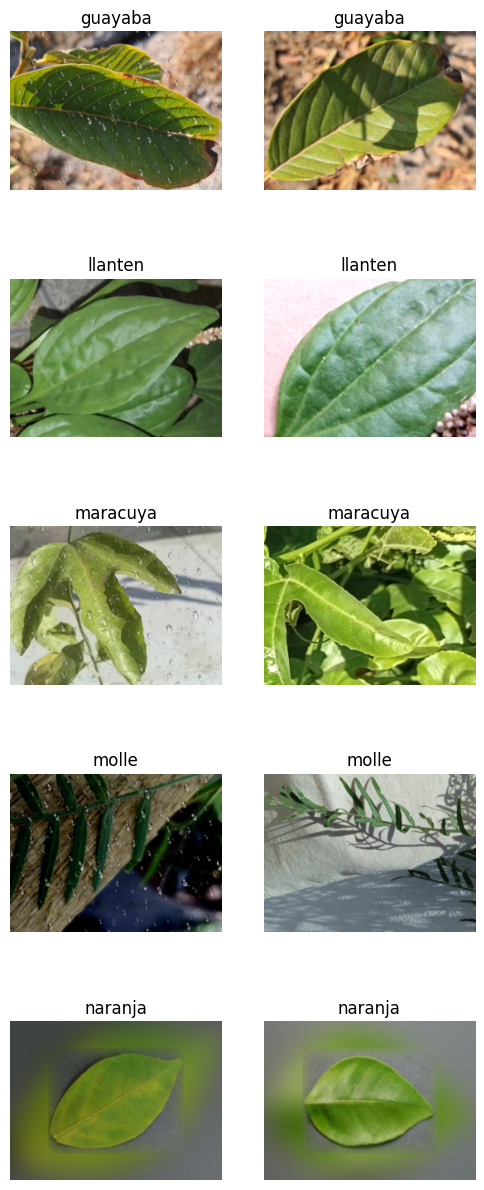

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

def show_images_per_class(original_dataset, subset, num_images_per_class=2):
    # Obtener las imágenes y etiquetas del subset
    data_loader = DataLoader(subset, batch_size=len(subset), shuffle=True)
    images, labels = next(iter(data_loader))

    # Convertir a NumPy para la visualización
    images = images.numpy().transpose((0, 2, 3, 1))  # Convertir de (N, C, H, W) a (N, H, W, C)
    labels = labels.numpy()

    # Crear un diccionario para almacenar imágenes por clase
    class_images = {i: [] for i in range(len(original_dataset.classes))}

    # Almacenar imágenes por clase
    for img, label in zip(images, labels):
        if len(class_images[label]) < num_images_per_class:
            class_images[label].append(img)

    # Visualizar imágenes
    r = len(class_images)
    c = num_images_per_class
    plt.figure(figsize=(c*3, r*3))

    for i, (class_id, imgs) in enumerate(class_images.items()):
        for j, img in enumerate(imgs):
            plt.subplot(r, c, i*c + j + 1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(original_dataset.classes[class_id])

    plt.subplots_adjust(wspace=0.2, hspace=0.5)
    plt.show()

# Llamar a la función para mostrar las imágenes
show_images_per_class(dataset, train_subset, num_images_per_class=2)


# Comprobacion de tipos de datos

Siguiendo las buenas prácticas, es importante verificar el tipo de datos con el que estamos trabajando. En este caso, confirmamos que los tipos de datos son correctos: torch.float32 para las imágenes y torch.int64 para las etiquetas. Estos tipos de datos son proporcionados por PyTorch al crear los tensores, lo que asegura que estén en el formato adecuado para el entrenamiento del modelo.

In [ ]:
# Obtener un batch de imágenes y etiquetas
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Verificar el tipo de dato de los tensores
print(f"Tipo de dato de train_images: {images.dtype}")
print(f"Tipo de dato de train_labels: {labels.dtype}")


Tipo de dato de train_images: torch.float32
Tipo de dato de train_labels: torch.int64


# Distrubicion de Datos

Seguidamente toca graficar la distribucion de los datos de todas las clases con las que vamos a trabajar.

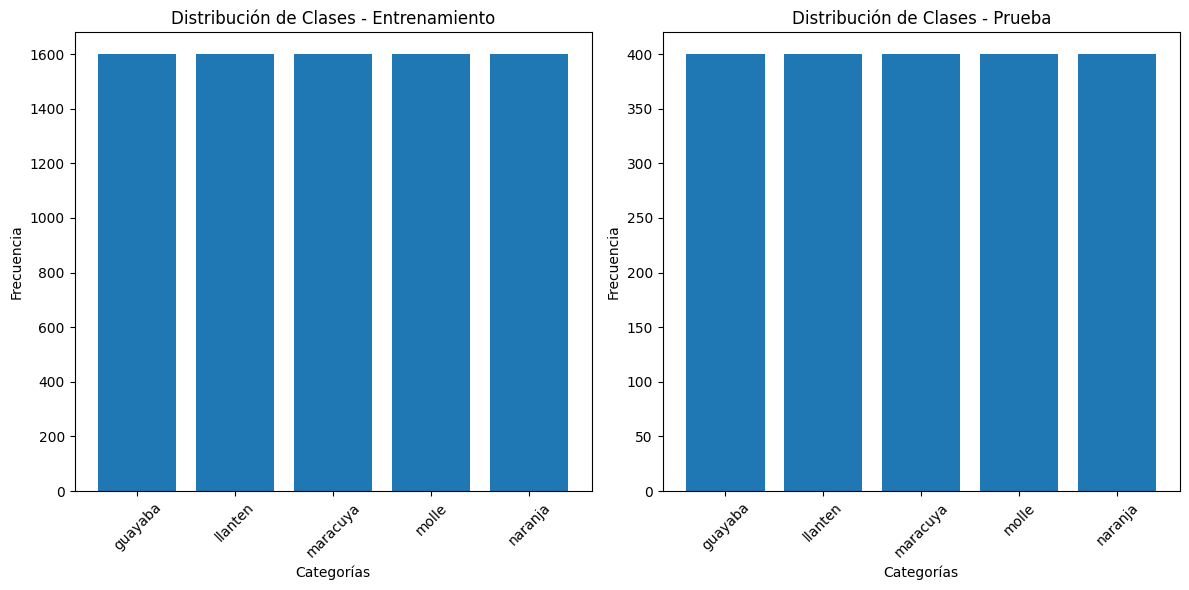

Categoría: guayaba, Conteo en Entrenamiento: 1600
Categoría: llanten, Conteo en Entrenamiento: 1600
Categoría: maracuya, Conteo en Entrenamiento: 1600
Categoría: molle, Conteo en Entrenamiento: 1600
Categoría: naranja, Conteo en Entrenamiento: 1600
Categoría: guayaba, Conteo en Prueba: 400
Categoría: llanten, Conteo en Prueba: 400
Categoría: maracuya, Conteo en Prueba: 400
Categoría: molle, Conteo en Prueba: 400
Categoría: naranja, Conteo en Prueba: 400


In [ ]:
import matplotlib.pyplot as plt
import torch
from collections import Counter
from torch.utils.data import DataLoader

def count_classes(loader):
    class_counts = Counter()
    for _, labels in loader:
        class_counts.update(labels.numpy())
    return class_counts

# Contar las clases en el conjunto de entrenamiento y prueba
train_class_counts = count_classes(train_loader)
test_class_counts = count_classes(test_loader)

# Convertir los contadores a listas para la visualización
num_classes = len(dataset.classes)
train_class_counts_list = [train_class_counts.get(i, 0) for i in range(num_classes)]
test_class_counts_list = [test_class_counts.get(i, 0) for i in range(num_classes)]

# Visualizar la distribución de clases para el conjunto de entrenamiento
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(range(num_classes), train_class_counts_list, tick_label=dataset.classes)
plt.xlabel('Categorías')
plt.ylabel('Frecuencia')
plt.title('Distribución de Clases - Entrenamiento')
plt.xticks(rotation=45)

# Visualizar la distribución de clases para el conjunto de prueba
plt.subplot(1, 2, 2)
plt.bar(range(num_classes), test_class_counts_list, tick_label=dataset.classes)
plt.xlabel('Categorías')
plt.ylabel('Frecuencia')
plt.title('Distribución de Clases - Prueba')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Mostrar valores únicos y conteos para entrenamiento y prueba
for category, count in enumerate(train_class_counts_list):
    print(f"Categoría: {dataset.classes[category]}, Conteo en Entrenamiento: {count}")

for category, count in enumerate(test_class_counts_list):
    print(f"Categoría: {dataset.classes[category]}, Conteo en Prueba: {count}")


Al analizar las gráficas de la distribución de datos de entrenamiento y prueba, podemos observar que todas las clases están bien equilibradas. No se observa una diferencia significativa en la cantidad de datos entre las clases, lo que indica que no se generará un sesgo hacia ninguna de ellas. Esta distribución equilibrada ayuda a garantizar que el modelo se entrene de manera justa y efectiva en todas las clases.

# Aplicando filtros manuales

Los filtros en procesamiento de imágenes destacan o atenuan características específicas para facilitar tareas como la detección de bordes y la reducción de ruido. Los filtros aplicados en este laboratorio incluyen el filtro de líneas verticales, que resalta transiciones verticales; el filtro de líneas horizontales, que destaca transiciones horizontales; y el filtro Laplaciano, que detecta bordes generales al calcular la segunda derivada de la intensidad de los píxeles.

El objetivo al aplicar estos filtros es observar cómo afectan a las imágenes y verificar su efectividad en la detección de características específicas. Este análisis permite entender mejor el comportamiento de cada filtro y cómo puede ser utilizado para extraer información relevante en el procesamiento de imágenes.

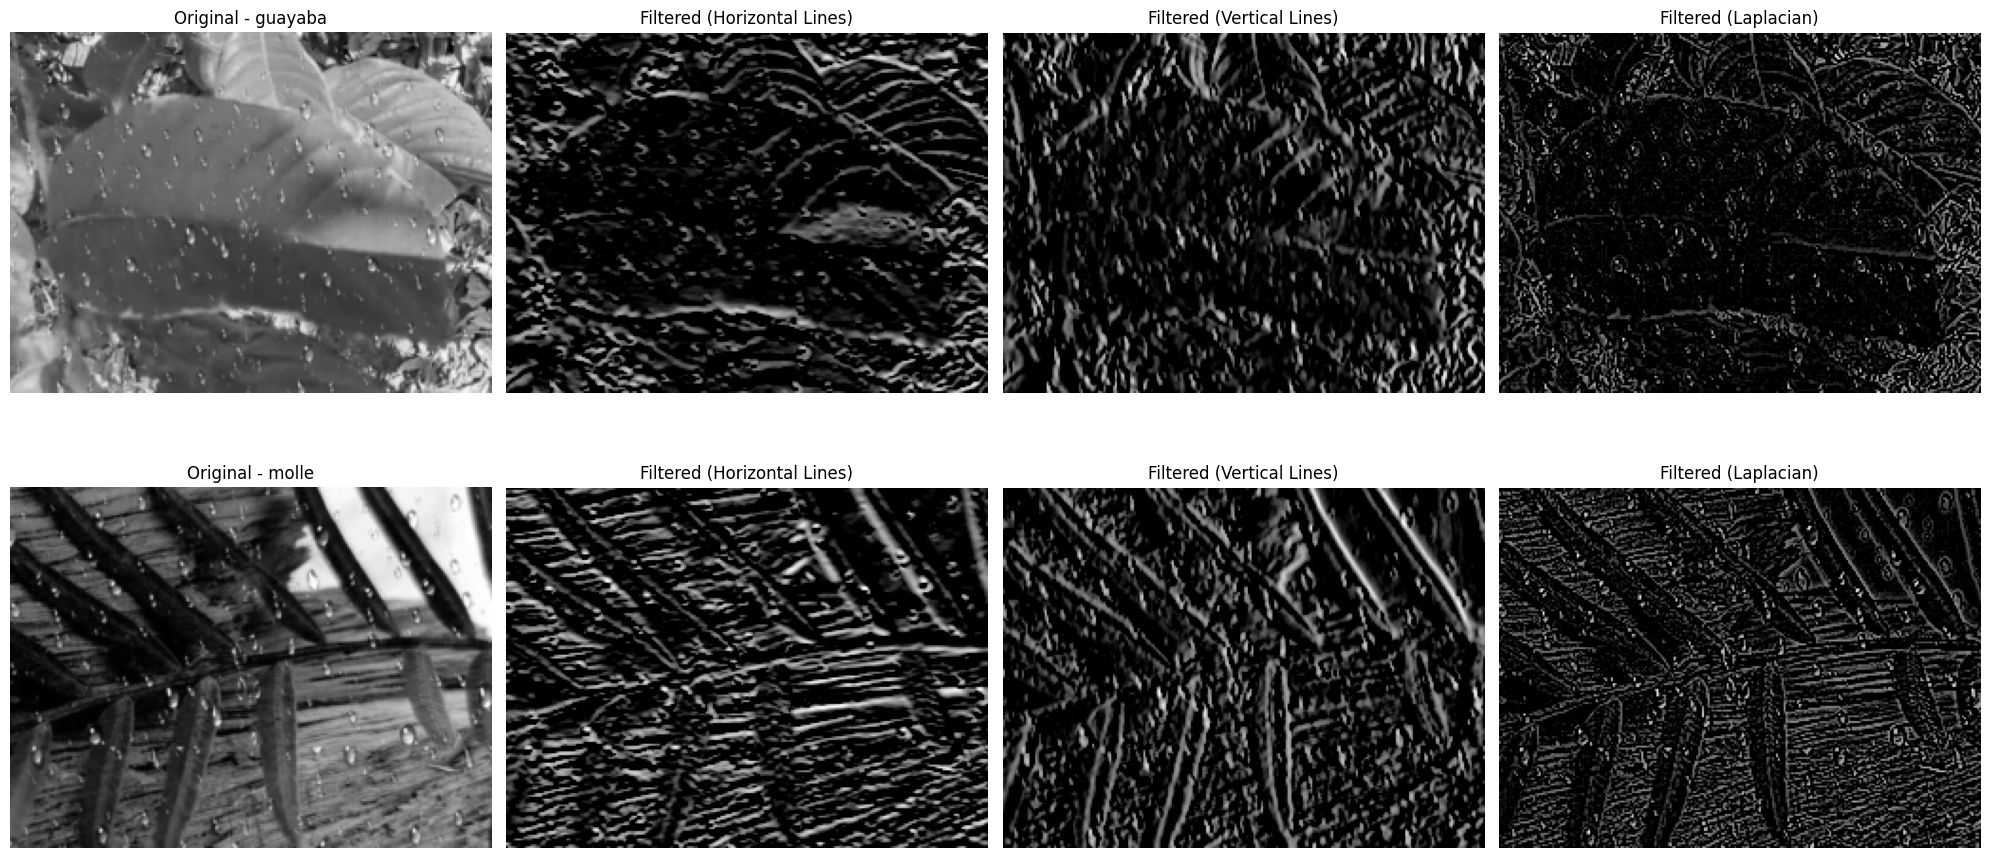

In [ ]:
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
import torch
from skimage import exposure

def apply_filter_to_tensor(tensor_img, kernel):
    # Convertir tensor a numpy array
    img_np = tensor_img.numpy().transpose(1, 2, 0)  # Convertir de (C, H, W) a (H, W, C)
    img_gray = np.mean(img_np, axis=2)  # Convertir a escala de grises (promedio de los canales)

    # Aplicar el kernel
    edges = scipy.signal.convolve2d(img_gray, kernel, mode='valid')

    # Normalizar y ajustar el histograma
    edges = exposure.equalize_adapthist(edges / np.max(np.abs(edges)), clip_limit=0.03)

    return edges

def show_filtered_images(images, labels, classes, kernel1, kernel2, kernel3):
    plt.figure(figsize=(20, len(images) * 5))

    for i in range(len(images)):
        img_tensor = images[i].numpy().transpose(1, 2, 0)  # Convertir de (C, H, W) a (H, W, C)
        img_gray = np.mean(img_tensor, axis=2)  # Convertir a escala de grises

        edges_kernel1 = apply_filter_to_tensor(images[i], kernel1)
        edges_kernel2 = apply_filter_to_tensor(images[i], kernel2)
        edges_kernel3 = apply_filter_to_tensor(images[i], kernel3)

        plt.subplot(len(images), 4, 4*i + 1)
        plt.imshow(img_gray, cmap='gray')
        plt.title(f'Original - {classes[labels[i]]}')
        plt.axis('off')

        plt.subplot(len(images), 4, 4*i + 2)
        plt.imshow(edges_kernel1, cmap='gray')
        plt.title('Filtered (Horizontal Lines)')
        plt.axis('off')

        plt.subplot(len(images), 4, 4*i + 3)
        plt.imshow(edges_kernel2, cmap='gray')
        plt.title('Filtered (Vertical Lines)')
        plt.axis('off')

        plt.subplot(len(images), 4, 4*i + 4)
        plt.imshow(edges_kernel3, cmap='gray')
        plt.title('Filtered (Laplacian)')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Definir los kernels
kernel_horizontal_lines = np.array([[1, 1, 1],
                                    [0, 0, 0],
                                    [-1, -1, -1]])

kernel_vertical_lines = np.array([[1, 0, -1],
                                  [1, 0, -1],
                                  [1, 0, -1]])

kernel_laplacian = np.array([[0, -1, 0],
                             [-1, 4, -1],
                             [0, -1, 0]])

# Obtener un batch de imágenes y etiquetas
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Mostrar imágenes originales y filtradas para las primeras dos imágenes del batch
show_filtered_images(images[:2], labels[:2], dataset.classes, kernel_horizontal_lines, kernel_vertical_lines, kernel_laplacian)


# Aplicando Filtros de Pythor con Conv2d

Aplicar filtros con capas convolucionales en PyTorch tiene ventajas significativas sobre los filtros manuales. Las capas convolucionales aprenden automáticamente las características relevantes durante el entrenamiento, adaptándose mejor a los datos y extrayendo representaciones complejas sin necesidad de definir explícitamente los kernels. Esto permite una mayor flexibilidad y precisión en la extracción de características, manejando múltiples canales y escalas de forma más eficiente.

Tamaño original: torch.Size([16, 3, 192, 256])
Tamaño después de la primera convolución: torch.Size([16, 10, 190, 254])
Tamaño después de la segunda convolución: torch.Size([16, 64, 190, 254])
Tamaño después de la tercera convolución: torch.Size([16, 128, 94, 126])


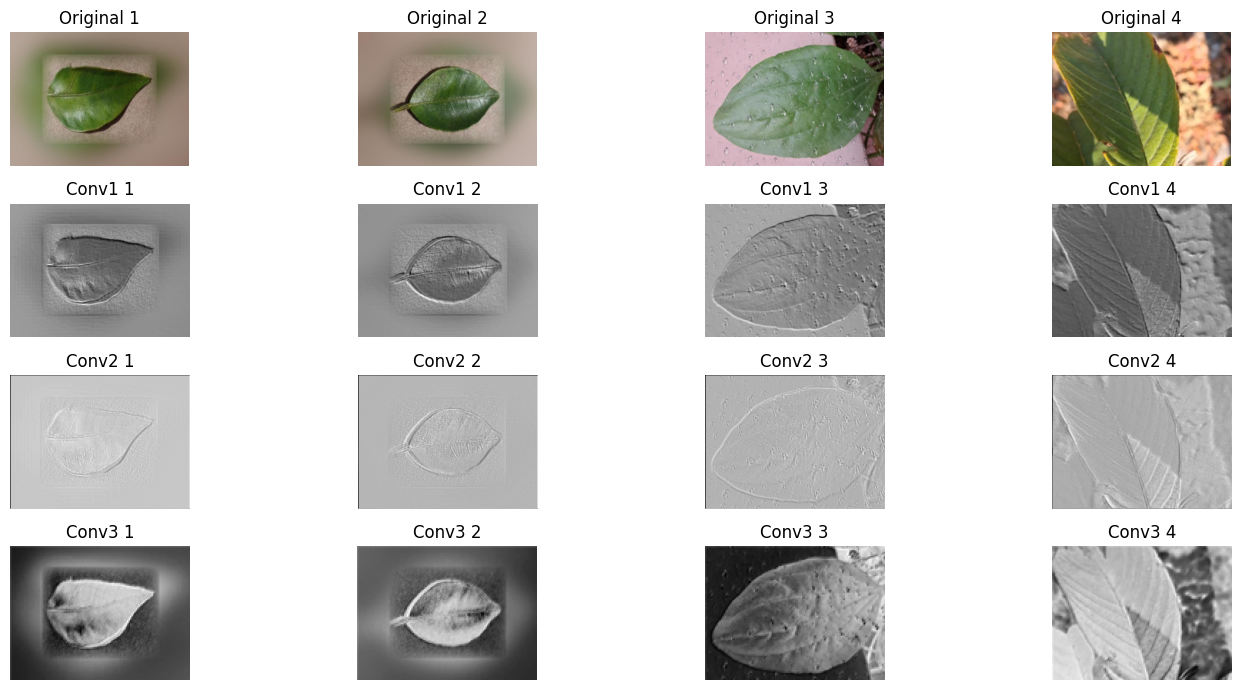

In [ ]:


# Definir las capas convolucionales
conv1 = torch.nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3)
conv2 = torch.nn.Conv2d(in_channels=10, out_channels=64, kernel_size=3, padding=1)
conv3 = torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2)

def apply_and_visualize_convolutions(data_loader):
    # Obtener un batch de imágenes
    for images, labels in data_loader:
        # Tamaño original
        original_size = images.size()
        print(f"Tamaño original: {original_size}")

        # Aplicar la primera capa convolucional
        output1 = conv1(images)
        size_after_conv1 = output1.size()
        print(f"Tamaño después de la primera convolución: {size_after_conv1}")

        # Aplicar la segunda capa convolucional sobre la salida de la primera
        output2 = conv2(output1)
        size_after_conv2 = output2.size()
        print(f"Tamaño después de la segunda convolución: {size_after_conv2}")

        # Aplicar la tercera capa convolucional sobre la salida de la segunda
        output3 = conv3(output2)
        size_after_conv3 = output3.size()
        print(f"Tamaño después de la tercera convolución: {size_after_conv3}")

        # Visualizar la imagen original y las salidas de las capas convolucionales
        num_images = min(4, images.size(0))  # Mostrar un máximo de 4 imágenes
        plt.figure(figsize=(15, 7))

        for i in range(num_images):
            plt.subplot(4, num_images, i + 1)
            plt.imshow(images[i].permute(1, 2, 0).numpy())
            plt.title(f'Original {i+1}')
            plt.axis('off')

            plt.subplot(4, num_images, num_images + i + 1)
            plt.imshow(output1[i].detach().numpy()[0], cmap='gray')
            plt.title(f'Conv1 {i+1}')
            plt.axis('off')

            plt.subplot(4, num_images, 2*num_images + i + 1)
            plt.imshow(output2[i].detach().numpy()[0], cmap='gray')
            plt.title(f'Conv2 {i+1}')
            plt.axis('off')

            plt.subplot(4, num_images, 3*num_images + i + 1)
            plt.imshow(output3[i].detach().numpy()[0], cmap='gray')
            plt.title(f'Conv3 {i+1}')
            plt.axis('off')

        plt.tight_layout()
        plt.show()
        break  # Solo necesitamos un batch para la visualización

# Aplicar y visualizar las convoluciones en el conjunto de entrenamiento
apply_and_visualize_convolutions(train_loader)


se aplican tres capas convolucionales a imágenes para extraer características en diferentes niveles. La primera capa convolucional (conv1) usa 10 filtros para detectar características básicas como bordes y texturas. La segunda capa (conv2), con 64 filtros, refina estas características y añade capacidad para capturar detalles más complejos mediante el uso de padding que mantiene el tamaño de la imagen. La tercera capa (conv3) aplica 128 filtros adicionales con un stride de 2, reduciendo la resolución espacial para detectar patrones aún más abstractos y complejos. Estas capas permiten capturar características desde lo básico hasta lo avanzado en las imágenes.

# Pooling

El pooling se utiliza para reducir la dimensión de las imágenes mientras se conservan las características más importantes. Esta técnica disminuye la cantidad de datos a procesar y la carga computacional, manteniendo solo las características más destacadas. En el caso del max pooling, se selecciona el valor máximo en cada región definida por el tamaño del kernel, mientras que el average pooling promedia todos los valores dentro del kernel. Ambos métodos ayudan a simplificar la información, pero de maneras diferentes, con el max pooling enfocándose en los valores más prominentes y el average pooling en una representación más general.

Tamaño original: torch.Size([16, 3, 192, 256])
Tamaño después de max pooling: torch.Size([16, 3, 96, 128])


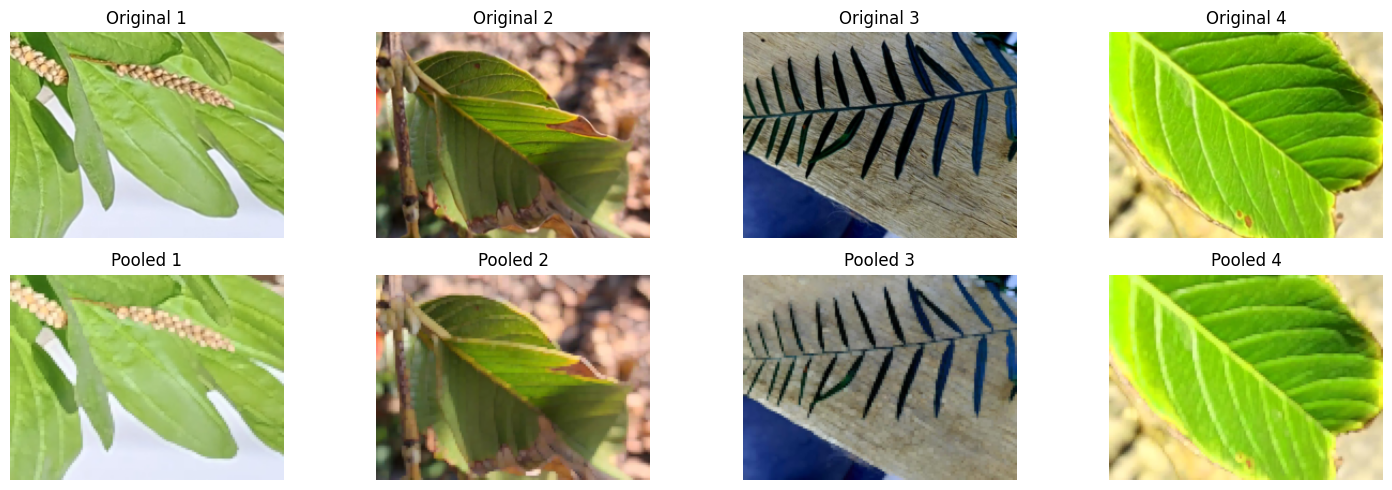

In [ ]:
# Definir la capa de max pooling
pool = torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

def apply_and_visualize_pooling(data_loader):
    # Obtener un batch de imágenes
    for images, labels in data_loader:
        # Tamaño original
        original_size = images.size()
        print(f"Tamaño original: {original_size}")

        # Aplicar max pooling
        pooled_output = pool(images)
        size_after_pooling = pooled_output.size()
        print(f"Tamaño después de max pooling: {size_after_pooling}")

        # Visualizar la imagen original y la salida de max pooling
        num_images = min(4, images.size(0))  # Mostrar un máximo de 4 imágenes
        plt.figure(figsize=(15, 5))

        for i in range(num_images):
            plt.subplot(2, num_images, i + 1)
            plt.imshow(images[i].permute(1, 2, 0).numpy())
            plt.title(f'Original {i+1}')
            plt.axis('off')

            plt.subplot(2, num_images, num_images + i + 1)
            plt.imshow(pooled_output[i].detach().numpy().transpose(1, 2, 0))
            plt.title(f'Pooled {i+1}')
            plt.axis('off')

        plt.tight_layout()
        plt.show()
        break  # Solo necesitamos un batch para la visualización

# Aplicar y visualizar max pooling en el conjunto de entrenamiento
apply_and_visualize_pooling(train_loader)

# Red ConVolucional

Se realiza una prueba con un lote de datos aleatorios para verificar que el tamaño de la salida del modelo coincida con el esperado. Este proceso ayuda a asegurar que las dimensiones de los tensores sean correctas y que el modelo esté configurado adecuadamente para procesar imágenes de entrada de tamaño específico.

In [ ]:
import torch
import torch.nn as nn

def block(c_in, c_out, k=3, p=1, s=1, pk=2, ps=2):
    return nn.Sequential(
        nn.Conv2d(c_in, c_out, k, padding=p, stride=s),
        nn.ReLU(),
        nn.MaxPool2d(pk, stride=ps)
    )

class CNN(nn.Module):
    def __init__(self, n_channels=3, n_outputs=5):
        super().__init__()
        self.conv1 = block(n_channels, 64)
        self.conv2 = block(64, 128)
        self.fc = nn.Linear(128 * 48 * 64, n_outputs)  # Ajustar el tamaño de la capa fc

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.shape[0], -1)  # Aplanar el tensor
        x = self.fc(x)
        return x

def print_tensor_shapes(model, dataloader):
    # Imprime las dimensiones de entrada y salida para una muestra
    for X, _ in dataloader['train']:
        print(f"Entrada: {X.size()}")
        X = X.to(next(model.parameters()).device)  # Mueve datos al dispositivo
        with torch.no_grad():
            y_hat = model(X)
        print(f"Salida: {y_hat.size()}")
        break  # Solo necesitamos una muestra para imprimir las dimensiones

    # Ejemplo para una muestra de cómo las dimensiones cambian después de cada capa
    print(f"Dimensiones:")
    x = torch.randn(16, 3, 192, 256)
    print(f"Entrada: {x.size()}")
    x = model.conv1(x)
    print(f"conv1: {x.size()}")
    x = model.conv2(x)
    print(f"conv2: {x.size()}")
    x = x.view(x.size(0), -1)  # Aplana para la capa FC
    print(f"pre fc: {x.size()}")
    x = model.fc(x)
    print(f"Salida: {x.size()}\n")

# Crear una instancia del modelo
model = CNN()

# Probar el modelo con un batch de ejemplo
output = model(torch.randn(16, 3, 192, 256))
print(f"Tamaño de la salida del modelo: {output.size()}")


Tamaño de la salida del modelo: torch.Size([16, 5])


Podemos ver que es correcto, ya que tenemos 5 clases que clasificar y 16 de batch size.

In [ ]:
import torch

def save_checkpoint(model, filename='ckpt.pt'):
    torch.save(model.state_dict(), filename)
    print(f"Checkpoint guardado en {filename}")

# Dentro de tu función `fit`, después de la validación:
def fit(model, dataloader, epochs=5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = torch.nn.CrossEntropyLoss()

    best_val_acc = 0

    for epoch in range(1, epochs + 1):
        model.train()
        train_loss, train_acc = [], []

        for batch in dataloader['train']:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)

        model.eval()
        val_loss, val_acc = [], []

        with torch.no_grad():
            for batch in dataloader['test']:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)

                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)

        # Imprimir los resultados al final de cada época
        print(f"Epoch {epoch}/{epochs} "
              f"loss {np.mean(train_loss):.5f} "
              f"val_loss {np.mean(val_loss):.5f} "
              f"acc {np.mean(train_acc):.5f} "
              f"val_acc {np.mean(val_acc):.5f}")

        # Guardar checkpoint si la precisión de validación es la mejor
        if np.mean(val_acc) > best_val_acc:
            best_val_acc = np.mean(val_acc)
            save_checkpoint(model, filename='best_ckpt.pt')


In [ ]:
import torch

# Verificar si CUDA está disponible
if torch.cuda.is_available():
    # Verificar el nombre de las GPUs disponibles
    print("Dispositivos CUDA disponibles:")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("CUDA no está disponible.")

Dispositivos CUDA disponibles:
GPU 0: NVIDIA GeForce GTX 1060 6GB


Ahora una vez comprobado que nuestro modelo funciona bien con datos aleatorios, es momento de probar con nuestro dataset con los dataloaders de entrenamiento y de prueba.

In [ ]:
# Crear y entrenar el modelo
model = CNN(n_channels=3, n_outputs=5)  # Ajustar el número de canales y salidas según tus datos
print_tensor_shapes(model, {'train': train_loader, 'test': test_loader})
fit(model, {'train': train_loader, 'test': test_loader})

Entrada: torch.Size([16, 3, 192, 256])
Salida: torch.Size([16, 5])
Dimensiones:
Entrada: torch.Size([16, 3, 192, 256])
conv1: torch.Size([16, 64, 96, 128])
conv2: torch.Size([16, 128, 48, 64])
pre fc: torch.Size([16, 393216])
Salida: torch.Size([16, 5])

Epoch 1/5 loss 0.65023 val_loss 0.50599 acc 0.76487 val_acc 0.81600
Checkpoint guardado en best_ckpt.pt
Epoch 2/5 loss 0.24532 val_loss 0.24531 acc 0.91525 val_acc 0.92100
Checkpoint guardado en best_ckpt.pt
Epoch 3/5 loss 0.13360 val_loss 0.17229 acc 0.95350 val_acc 0.93900
Checkpoint guardado en best_ckpt.pt
Epoch 4/5 loss 0.09371 val_loss 0.25762 acc 0.97000 val_acc 0.92050
Epoch 5/5 loss 0.07532 val_loss 0.19224 acc 0.97537 val_acc 0.94600
Checkpoint guardado en best_ckpt.pt


Observamos que obtuvimos un excelente rendimiento en la predicción con solo 5 épocas de entrenamiento. Esta es una de las principales ventajas de utilizar redes neuronales convolucionales: extraen las características más relevantes de manera eficiente, lo que reduce la carga computacional y permite un mejor entrenamiento de la capa MLP.

/tmp/ipykernel_13733/1206368022.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_ckpt.pt'))


Precisión en el conjunto de prueba: 0.9460


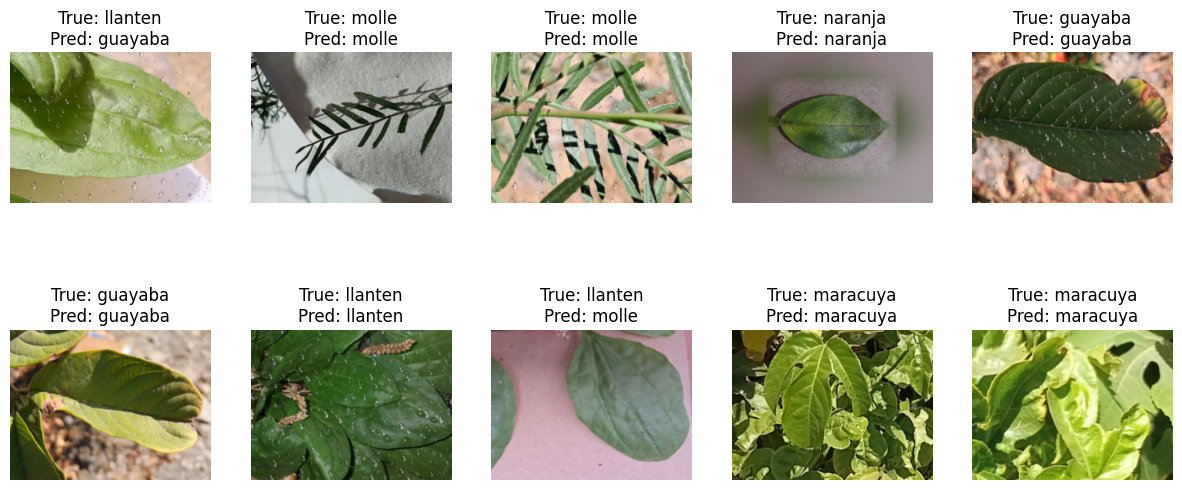

In [ ]:
model = CNN()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Cargar el estado del modelo guardado
model.load_state_dict(torch.load('best_ckpt.pt'))
model.eval()  # Establecer el modelo en modo de evaluación

def evaluate_model(model, dataloader):
    all_labels = []
    all_predictions = []
    all_images = []  # Para almacenar imágenes para la visualización

    with torch.no_grad():
        for images, labels in dataloader:
            # Mover los datos al dispositivo
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            all_images.extend(images.cpu())

    # Seleccionar 10 índices aleatorios
    num_samples = 10
    indices = np.random.choice(len(all_images), num_samples, replace=False)
    random_images = [all_images[i] for i in indices]
    random_labels = [all_labels[i] for i in indices]
    random_predictions = [all_predictions[i] for i in indices]

    accuracy = (np.array(all_labels) == np.array(all_predictions)).mean()
    return accuracy, random_images, random_labels, random_predictions

# Evaluar el modelo en el conjunto de prueba
test_accuracy, sample_images, sample_labels, sample_predictions = evaluate_model(model, test_loader)
print(f"Precisión en el conjunto de prueba: {test_accuracy:.4f}")

# Función para desaplanar y visualizar imágenes con nombre de la clase y predicción
def unflatten_and_show(images, labels, predictions, classes, original_size=(192, 256)):
    num_images = len(images)
    images_unflattened = [img.permute(1, 2, 0).numpy() for img in images]  # Convertir a numpy array

    # Visualizar las imágenes
    r, c = 2, 5  # 2 filas, 5 columnas
    plt.figure(figsize=(c*3, r*3))

    for i in range(num_images):
        plt.subplot(r, c, i + 1)
        img = images_unflattened[i]
        label = labels[i]
        pred = predictions[i]
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"True: {classes[label]}\nPred: {classes[pred]}")  # Mostrar la clase verdadera y la predicción

    plt.subplots_adjust(wspace=0.2, hspace=0.5)
    plt.show()

# Mostrar imágenes con sus predicciones
unflatten_and_show(sample_images, sample_labels, sample_predictions, dataset.classes)



Para concluir, se realizaron predicciones sobre un conjunto de imágenes y se visualizaron junto a las imágenes correspondientes para evaluar el desempeño del modelo de manera visual. Esto no solo permite analizar la precisión a través de métricas textuales, sino también verificar cómo el modelo clasifica las imágenes en la práctica, comparando las predicciones con las clases reales.

In [ ]:
torch.cuda.empty_cache()